In [3]:
# Implement all the libraries we need 

%matplotlib inline
import re
import io
import urllib2
import networkx as nx
import json
import glob
import numpy as np
import operator
import matplotlib.pyplot as plt
import time
import networkx as nx
import os.path
from __future__ import division
from pprint import pprint
import community

In [56]:
# Get JSON reply using the URL
def getJSONReply(URL):
    response = urllib2.urlopen(URL);
    html = response.read();
    data = json.loads(html);
    return data;

def getUserInput():
    FileExists=os.path.isfile('RitoMongo.conf') ;
    res=[];
    if (FileExists):
        with open('RitoMongo.conf') as f:
            for line in f:
                res.append(line.rstrip('\n'));
                print line.rstrip('\n');
    elif (not FileExists):
        SummonerName= raw_input('Enter your Summoner name: ');
        Region  = (raw_input('Enter your region: ')).upper();
        Key = raw_input('Enter your API Key which you retrieved from Riot website: ');
        f = open('RitoMongo.conf','w');
        f.write(SummonerName+'\n'+Region+'\n'+Key);
        f.close();
    return res;

# Using the game-v1.3 API to get each player's recent history      
def getRecentHistory(SummonerID):
        rURL= "https://" +Region.lower()+ ".api.pvp.net/api/lol/" + \
        Region.lower()+ "/v1.3/game/by-summoner/" + SummonerID+ "/recent?api_key=" + Key;
        r_data=getJSONReply(rURL);
        r_data['_id']=r_data['summonerId'];
        r_data.pop('summonerId');
        # Write the data to a local json file, naming it after this Summoner's ID
        with io.open('RecentHistory/%s.json' % str(SummonerID), 'w', encoding='utf-8') as f:
            f.write(unicode(json.dumps(r_data, ensure_ascii=False)))
        return r_data;

def getMatchlist(SummonerID):
        rURL= "https://" +Region.lower()+ ".api.pvp.net/api/lol/" + Region.lower()+ "/v2.2/matchlist/by-summoner/" + `SummonerID`+ "/?api_key=" + Key
        r_data=getJSONReply(rURL);
        return r_data

def getMatch(MatchID):
        rURL= "https://" +Region.lower()+ ".api.pvp.net/api/lol/" + Region.lower()+ "/v2.2/match/" + `MatchID`+ "/?api_key=" + Key
        r_data=getJSONReply(rURL);
        with io.open('Match/%s.json' % str(MatchID), 'w', encoding='utf-8') as f:
             f.write(unicode(json.dumps(r_data, ensure_ascii=False)))
        return r_data 

# Using the championmastery API to get each player's mastery of the champions
def getChampion(SummonerID):
        rURL= "https://" +Region.lower()+ ".api.pvp.net/championmastery/location/"\
        + Region+ "1/player/" + `SummonerID`+ "/champions?api_key=" + Key
        r_data=getJSONReply(rURL)
        # Write the data to a local json file, naming it after this Summoner's ID
        with io.open('Champion/%s.json' % str(SummonerID), 'w', encoding='utf-8') as f:
             f.write(unicode(json.dumps(r_data, ensure_ascii=False)))
        return r_data 

# Using the summoner-v1.4 API to get each player's identity information by their names
def ReformatJSON(SummonerName,Region,Key):
    idURL = "https://" +Region.lower()+ ".api.pvp.net/api/lol/" +Region.lower()+ "/v1.4/summoner/by-name/" + SummonerName+ "?api_key=" + Key
    id_data = getJSONReply(idURL)
    idRes=id_data[SummonerName.lower()]
    idRes['_id'] = idRes['id']
    idRes.pop('id')
    return idRes,id_data

# Using the summoner-v1.4 API to get each player's identity information by their IDs
def ReformatJSONbyid(SummonerID,Region,Key):
    idURL = "https://" +Region.lower()+ ".api.pvp.net/api/lol/" +Region.lower()+ "/v1.4/summoner/" +SummonerID+ "?api_key=" +Key
    id_data = getJSONReply(idURL)
    idRes=id_data[SummonerID]
    idRes['_id'] = idRes['id']
    idRes.pop('id')
    # Write the data to a local json file, naming it after this Summoner's ID
    with io.open('Summoner/%s.json' % str(SummonerID), 'w', encoding='utf-8') as f:
          f.write(unicode(json.dumps(idRes, ensure_ascii=False)))
    return idRes,id_data

In [59]:
#================================= Main =============================================================================
SummonerName="Miladena"
Region="EUW"
Key="RGAPI-20253dda-c325-4a7e-947a-d283af4f8641"

# Retrieving the SummonerID;
idURL,id_data=ReformatJSON(SummonerName,Region,Key)

SummonerID=id_data[SummonerName.lower()]["_id"]
rdata=getRecentHistory(str(SummonerID))
print type(rdata)
matchlist=getMatchlist(SummonerID)

#Connecting to mongoDB database
#client = MongoClient();
#db = client['RitoMongoDB'];
#SummonerID_Collection = db["SummonerID"];
#RecentHistory_Collection = db["RecentHistory"];
#entryID = SummonerID_Collection.insert_one({str(SummonerID):idURL}).inserted_id;
#entryID = RecentHistory_Collection.insert_one({str(SummonerID):rdata}).inserted_id;
#client.close();

KeyboardInterrupt: 

In [60]:
type(rdata)

dict

In [180]:
len(rdata["games"][1]["fellowPlayers"])

9

In [237]:
# Generate an id list to store a huge amount of summoner ids
idlist = [SummonerID]

# Iterate calling the API, 
# get each summoner's 10 recent games,
# find their fellow players in each game
# save their summoner id to a list, 'idlist'
for k in range(10):
    rdata=getRecentHistory(idlist[k])
    for i in range(len(rdata["games"])):
        # In some kinds of games, player doesn't have fellow players
        if "fellowPlayers" not in rdata["games"][i].keys():
            continue
        for j in range(len(rdata["games"][i]["fellowPlayers"])):
            idlist.append(rdata["games"][i]["fellowPlayers"][j]["summonerId"])           
            
print len(set(idlist))

636


In [257]:
SummonerName="HARIKAYIM"

# Retrieving the SummonerID;
idURL,id_data=ReformatJSON(SummonerName,Region,Key)
SummonerID=id_data[SummonerName.lower()]["_id"]
rdata=getRecentHistory(SummonerID)
matchlist=getMatchlist(SummonerID)

for i in range(len(rdata["games"])):
        if "fellowPlayers" not in rdata["games"][i].keys():
            continue
        for j in range(len(rdata["games"][i]["fellowPlayers"])):
            idlist.append(rdata["games"][i]["fellowPlayers"][j]["summonerId"]) 

In [300]:
for k in range(19500,19510):
    rdata=getRecentHistory(idlist[k])
    for i in range(len(rdata["games"])):
        if "fellowPlayers" not in rdata["games"][i].keys():
            continue
        for j in range(len(rdata["games"][i]["fellowPlayers"])):
            idlist.append(rdata["games"][i]["fellowPlayers"][j]["summonerId"])           
            
print len(set(idlist))

20192


In [165]:
uni = unicode(str(uniidlist), encoding='UTF-8')
with io.open('idlist.txt' , 'w', encoding='utf-8') as f:
       f.write(uni)

In [6]:
with io.open('idlist.txt' , 'r', encoding='utf-8') as f:
       idlist = f.read()
idlist = list(set(idlist[1:-1].split(', ')))
uniidlist = []
for i in idlist:
    uniidlist.append(int(i))

In [47]:
len(uniidlist)

20192

In [164]:
for k in range(67990,68000):
    rdata=getRecentHistory(str(uniidlist[k]))
    for i in range(len(rdata["games"])):
        if "fellowPlayers" not in rdata["games"][i].keys():
            continue
        for j in range(len(rdata["games"][i]["fellowPlayers"])):
            uniidlist.append(rdata["games"][i]["fellowPlayers"][j]["summonerId"])           
            
print len(set(uniidlist))

69054


In [163]:
for k in range(67690,67700):
    rdata=getRecentHistory(str(uniidlist[k]))
    for i in range(len(rdata["games"])):
        if "fellowPlayers" not in rdata["games"][i].keys():
            continue
        for j in range(len(rdata["games"][i]["fellowPlayers"])):
            uniidlist.append(rdata["games"][i]["fellowPlayers"][j]["summonerId"])           
            
print len(set(uniidlist))

68519


In [7]:
uniidlist = list(set(uniidlist))

In [8]:
len(uniidlist)

69054

In [319]:
i=0
# With summoner id list, we get their 10 recent games one by one
for gamer in uniidlist:
    idURL,id_data=ReformatJSONbyid(str(gamer),Region,Key)
    # Because of the API call limit, we have to use time.sleep()
    time.sleep(0.8)
    rdata=getRecentHistory(gamer)
    i += 1
    print i
    time.sleep(0.8)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


HTTPError: HTTP Error 429: Too Many Requests

In [9]:
i = 30000

In [72]:
for gamer in uniidlist[39552:]:
    idURL,id_data=ReformatJSONbyid(str(gamer),Region,Key)
    time.sleep(0.8)
    rdata=getRecentHistory(str(gamer))
    i += 1
    print i
    time.sleep(0.8)

39553
39554
39555
39556
39557
39558
39559
39560
39561
39562
39563
39564
39565
39566
39567
39568
39569
39570
39571
39572
39573
39574
39575
39576
39577
39578
39579
39580
39581
39582
39583
39584
39585
39586
39587
39588
39589
39590
39591
39592
39593
39594
39595
39596
39597
39598
39599
39600
39601
39602
39603
39604
39605
39606
39607
39608
39609
39610
39611
39612
39613
39614
39615
39616
39617
39618
39619
39620
39621
39622
39623
39624
39625
39626
39627
39628
39629
39630
39631
39632
39633
39634
39635
39636
39637
39638
39639
39640
39641
39642
39643
39644
39645
39646
39647
39648
39649
39650
39651
39652
39653
39654
39655
39656
39657
39658
39659
39660
39661
39662
39663
39664
39665
39666
39667
39668
39669
39670
39671
39672
39673
39674
39675
39676
39677
39678
39679
39680
39681
39682
39683
39684
39685
39686
39687
39688
39689
39690
39691
39692
39693
39694
39695
39696
39697
39698
39699
39700
39701
39702
39703
39704
39705
39706
39707
39708
39709
39710
39711
39712
39713
39714
39715
39716
39717
39718
3971

HTTPError: HTTP Error 500: Server Error

In [363]:
def f(x):
    i=0
    for gamer in uniidlist[x:x+101]:
        idURL,id_data=ReformatJSONbyid(str(gamer),Region,Key)
        time.sleep(0.8)
        rdata=getRecentHistory(gamer)
        i += 1
        print i
        time.sleep(0.8)

In [364]:
map(f,[8443,8543])

1
2
3
4


HTTPError: HTTP Error 500: Server Error

In [171]:
rdata["games"]

[{u'championId': 154,
  u'createDate': 1479476239604,
  u'fellowPlayers': [{u'championId': 43,
    u'summonerId': 52228480,
    u'teamId': 100},
   {u'championId': 201, u'summonerId': 39494918, u'teamId': 200},
   {u'championId': 4, u'summonerId': 60308035, u'teamId': 100},
   {u'championId': 39, u'summonerId': 19645038, u'teamId': 200},
   {u'championId': 81, u'summonerId': 40484091, u'teamId': 200},
   {u'championId': 254, u'summonerId': 23056375, u'teamId': 200},
   {u'championId': 55, u'summonerId': 44293319, u'teamId': 200},
   {u'championId': 114, u'summonerId': 53387769, u'teamId': 100},
   {u'championId': 67, u'summonerId': 29478701, u'teamId': 100}],
  u'gameId': 2937818935,
  u'gameMode': u'CLASSIC',
  u'gameType': u'MATCHED_GAME',
  u'invalid': False,
  u'ipEarned': 108,
  u'level': 30,
  u'mapId': 11,
  u'spell1': 4,
  u'spell2': 11,
  u'stats': {u'assists': 22,
   u'championsKilled': 6,
   u'doubleKills': 1,
   u'goldEarned': 16817,
   u'goldSpent': 13850,
   u'item0': 101

In [ ]:
win_rate = [0]*(max(championid)+1)
win = [0]*(max(championid)+1)
total = [0]*(max(championid)+1)
for i in range(len(match)):
    for j in range(len(match[i]["teams"])):
        for k in range(len(match[i]["teams"][j]["bans"])):
            champid = match[i]["teams"][j]["bans"][0]["championId"] 
            if match[i]["teams"][j]["winner"]:
                win[champid] += 1
            total[champid] += 1
for i in range(max(championid)+1):
    if total[i] == 0:
        win_rate[i] = 0
    else:
        win_rate[i] = win[i]/total[i]
print win_rate

In [302]:
matchlist["matches"][1]

{u'champion': 120,
 u'lane': u'JUNGLE',
 u'matchId': 2936114762,
 u'platformId': u'EUW1',
 u'queue': u'RANKED_FLEX_SR',
 u'region': u'EUW',
 u'role': u'NONE',
 u'season': u'PRESEASON2017',
 u'timestamp': 1479334033814}

In [310]:
matchid = []
for i in range(len(matchlist["matches"])):
    matchid.append(matchlist["matches"][i]["matchId"])
print len(matchid)
match = []
for j in range(5):
    start_time = time.time()
    time.sleep(0.5)
    match.append(getMatch(matchid[j]))
    time.sleep(0.5)
    print("--- %s seconds ---" % (time.time() - start_time)) 
for j in range(5,10):
    start_time = time.time()
    time.sleep(0.5)
    match.append(getMatch(matchid[j]))
    time.sleep(0.5)
    print("--- %s seconds ---" % (time.time() - start_time))

464
--- 1.5532181263 seconds ---
--- 1.57335495949 seconds ---


HTTPError: HTTP Error 429: Too Many Requests

In [123]:
uni = unicode(str(matchid), encoding='UTF-8')
with io.open('matchid.txt' , 'w', encoding='utf-8') as f:
       f.write(uni)

In [146]:
summonerid = []
for j in range(len(match)):
    temp = []
    for i in range(len(match[j]["participantIdentities"])):
        temp.append(match[j]["participantIdentities"][i]["player"]["summonerId"])
    summonerid.append(temp)
print summonerid

[[35257388, 44738810, 20951688, 25126971, 42277340, 22901273, 76660449, 28255897, 29737467, 29896423]]


In [107]:
len(summonerid)

20

In [110]:
G=nx.Graph()
for j in range(len(idlist)):
    for i in range(10):
        for k in range(i+1,10):
            G.add_edge(summonerid[j][i],summonerid[j][k])

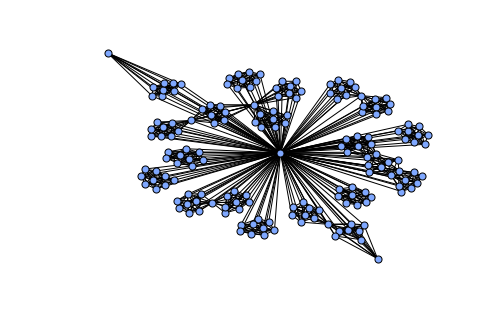

In [113]:
nx.draw_spring(G, node_size=50, with_labels=False, node_color='#7FA8FF')
plt.show()

In [52]:
championid = []
for i in range(len(match)):
    for j in range(len(match[i]["participants"])):
        championid.append(match[i]["participants"][j]["championId"])

In [53]:
len(championid)

50

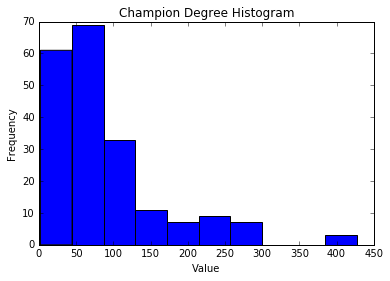

In [127]:
numbers = championid
np.histogram(numbers, bins=78, range=None, normed=False, weights=None, density=None)
plt.hist(numbers)
plt.title("Champion Degree Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")

In [139]:
freq = {key:len(list(group)) for key, group in groupby(np.sort(championid))}
y = freq.values()
x = freq.keys()

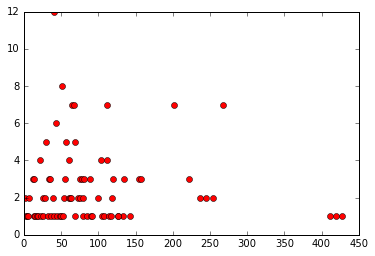

In [146]:
plt.figure()
plt.plot(x, y, "ro")
plt.show()

In [14]:
SummonerID_Collection.find_one()

{u'_id': 63173967,
 u'name': u'BrtAnn',
 u'profileIconId': 1301,
 u'revisionDate': 1479311427000L,
 u'summonerLevel': 19}

In [104]:
SummonerName="BrtAnn";
Region="EUNE";
Key="RGAPI-20253dda-c325-4a7e-947a-d283af4f8641";
idURL = "https://eune.api.pvp.net/api/lol/eune/v1.4/summoner/63173967?api_key=RGAPI-20253dda-c325-4a7e-947a-d283af4f8641"
id_data = getJSONReply(idURL);
print id_data

{u'63173967': {u'profileIconId': 1301, u'summonerLevel': 19, u'revisionDate': 1479317698000, u'id': 63173967, u'name': u'BrtAnn'}}


In [147]:
idlist = [SummonerID]
for i in range(len(rdata["games"])):
    for j in range(len(rdata["games"][i]["fellowPlayers"])):
        idlist.append(rdata["games"][i]["fellowPlayers"][j]["summonerId"])
len(set(idlist))

90

In [148]:
for gamer in idlist:
    idURL,id_data=ReformatJSONbyid(str(gamer),Region,Key)
    time.sleep(1)
    rdata=getRecentHistory(gamer)
    time.sleep(1)
    #entryID = SummonerID_Collection.insert_one({str(gamer):idURL}).inserted_id
    #entryID = RecentHistory_Collection.insert_one({str(gamer):rdata}).inserted_id

IOError: [Errno 2] No such file or directory: 'Summoner/29896423.txt'

In [44]:
i = 0
for item in SummonerID_Collection.find():
    print item
    i += 1
print i

RecentHistory_Collection.drop()

0


In [138]:
print db.SummonerID_Collection.find_one()

None
